### Dependencies & Prerequisites


In [ ]:
# !pip install -Uq corner

In [ ]:
#@title Import { display-mode: "form" }


import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


### Load Dataset

In [ ]:
datasets, datasets_info = tfds.load(
    name='mnist', with_info=True, as_supervised=False)

target_digit = 1
ratio = .8
target_dist = np.ones(10) / 9 * (1-ratio)
target_dist[target_digit] = ratio

blended_dataset = (
    datasets['train']
    .rejection_resample(lambda input: input['label'],
                        target_dist=target_dist,
                        initial_dist=np.ones(10) / 10)
    )

def preprocess_image(input_img):
    image = tf.cast(input_img, tf.float32) / 255. # Scale to unit interval.
    # image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image

def _preprocess(sample):
    image = preprocess_image(sample['image'])
    return image, image

batch_size = 256
train_dataset = (blended_dataset
                 .map(lambda _, x: _preprocess(x))
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3))
                 )
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE)
                )

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



### VAE on MNIST

Adapted from https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE

#### Specify model.

In [ ]:
input_shape = datasets_info.features['image'].shape
encoded_size = 2
base_depth = 32

In [ ]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [ ]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [ ]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [ ]:
vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

#### Do inference.

In [ ]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=20,
            validation_data=eval_dataset)

Epoch 1/20
34/34 [==============================] - 39s 214ms/step - loss: 271.0050 - val_loss: 250.8284
Epoch 2/20
34/34 [==============================] - 14s 178ms/step - loss: 133.1688 - val_loss: 209.0402
Epoch 3/20
34/34 [==============================] - 15s 169ms/step - loss: 116.6643 - val_loss: 203.7599
Epoch 4/20
34/34 [==============================] - 14s 157ms/step - loss: 105.6321 - val_loss: 195.7788
Epoch 5/20
34/34 [==============================] - 15s 181ms/step - loss: 97.3368 - val_loss: 187.9991
Epoch 6/20
34/34 [==============================] - 14s 152ms/step - loss: 93.8173 - val_loss: 185.8893
Epoch 7/20
34/34 [==============================] - 16s 177ms/step - loss: 92.2541 - val_loss: 184.4462
Epoch 8/20
34/34 [==============================] - 15s 182ms/step - loss: 91.1724 - val_loss: 183.1922
Epoch 9/20
34/34 [==============================] - 15s 171ms/step - loss: 89.5675 - val_loss: 181.3241
Epoch 10/20
34/34 [==============================] - 15s 178

### Inspect result

In [ ]:
# We'll just examine ten random digits.
x = next(iter(train_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [ ]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Originals:


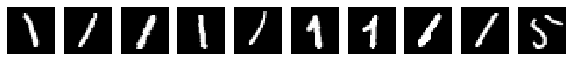

Decoded Random Samples:


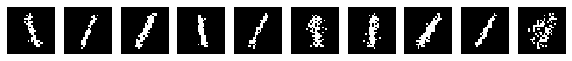

Decoded Modes:


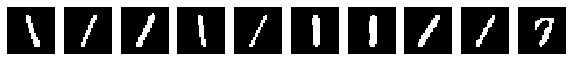

Decoded Means:


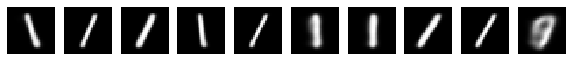

In [ ]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [ ]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


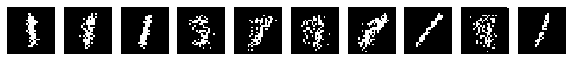

Randomly Generated Modes:


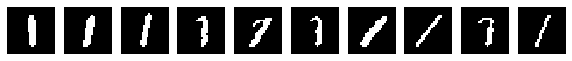

Randomly Generated Means:


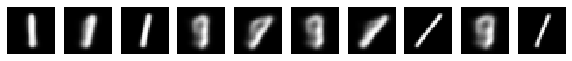

In [ ]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

Inspect the latent space (with label)

In [ ]:
def _preprocess2(_, sample):
    image = preprocess_image(sample['image'])
    return image, sample['label']

output = list(blended_dataset
          .map(_preprocess2)
          .batch(1000)
          .take(1)
          .as_numpy_iterator()
          )[0]
output_image = output[0]
output_label = output[1]

In [ ]:
z_mean = encoder(output_image).mean().numpy()
z_sample = encoder(output_image).sample().numpy()

In [ ]:
# import corner
# figure = corner.corner(z_sample)

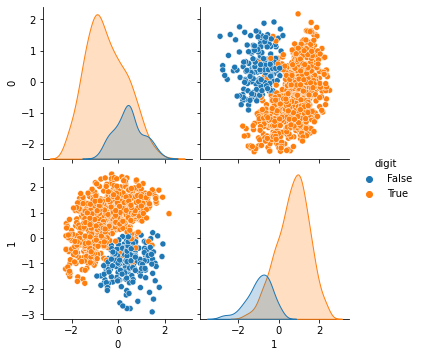

In [ ]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(z_mean)
df['digit'] = output_label == target_digit

sns.pairplot(df, hue="digit");

### Train Flow network

In [ ]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
def make_MAF(hidden_units=[16, 16], activation='relu'):
    MADE = tfb.AutoregressiveNetwork(
        params=encoded_size,
        event_shape=[encoded_size],
        hidden_units=hidden_units,
        activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=MADE)

In [ ]:
class Flow(tfk.layers.Layer):
    def __init__(self, encoded_size, num_bijectors):
        super(Flow, self).__init__()
        self.encoded_size = encoded_size
        self.num_bijectors = num_bijectors

    def build(self, input_shape):
        bijectors = []

        for i in range(self.num_bijectors):
            masked_auto_i = make_MAF(hidden_units=[256, 256],
                                    activation='relu')
            bijectors.append(masked_auto_i)
            bijectors.append(tfb.Permute(permutation=[1, 0]))

        flow_bijectors = tfb.Chain(list(reversed(bijectors[:-1])))

        base_dist = tfd.Sample(tfd.Normal(loc=0, scale=1), self.encoded_size)
        self.trainable_dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijectors)

    def call(self, inputs):
        return self.trainable_dist.log_prob(inputs)

flow_layer = Flow(encoded_size, num_bijectors=6)
logp_untrained = flow_layer(z_mean)

In [ ]:
encoder.trainable = False
flow = tfk.Model(inputs=encoder.inputs,
                 outputs=flow_layer(encoder.outputs[0]))

flow.compile(optimizer=tf.optimizers.Adam(),
             loss=lambda _, log_prob: -log_prob)

batch_size = 1000
_ = flow.fit(train_dataset.unbatch().batch(batch_size),
             epochs=20,
             validation_data=eval_dataset)

Epoch 1/20
9/9 [==============================] - 20s 426ms/step - loss: 11.2617 - val_loss: 12.1364
Epoch 2/20
9/9 [==============================] - 11s 248ms/step - loss: 11.1894 - val_loss: 11.9709
Epoch 3/20
9/9 [==============================] - 11s 252ms/step - loss: 11.1583 - val_loss: 12.0144
Epoch 4/20
9/9 [==============================] - 11s 248ms/step - loss: 11.1439 - val_loss: 11.9428
Epoch 5/20
9/9 [==============================] - 12s 239ms/step - loss: 11.0746 - val_loss: 12.0244
Epoch 6/20
9/9 [==============================] - 11s 240ms/step - loss: 11.0757 - val_loss: 11.9831
Epoch 7/20
9/9 [==============================] - 11s 239ms/step - loss: 11.0810 - val_loss: 12.0595
Epoch 8/20
9/9 [==============================] - 12s 325ms/step - loss: 11.1028 - val_loss: 12.0630
Epoch 9/20
9/9 [==============================] - 12s 251ms/step - loss: 11.1099 - val_loss: 11.9545
Epoch 10/20
9/9 [==============================] - 11s 246ms/step - loss: 11.1271 - val_los

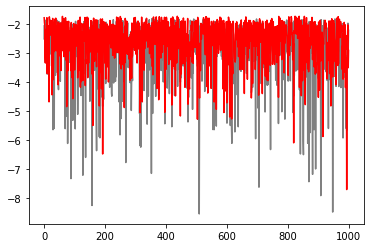

In [ ]:
logp_trained = flow_layer(z_mean)
# logp_trained = flow_layer.trainable_dist.log_prob(encoder(output_image))
plt.plot(logp_untrained, color='gray')
plt.plot(logp_trained, color='r');

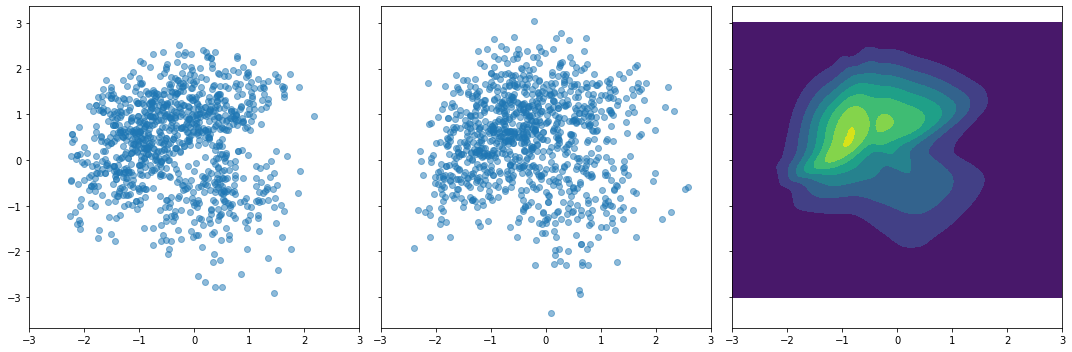

In [ ]:
flow_samples = flow_layer.trainable_dist.sample(1000)

_, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].scatter(df[0], df[1], alpha=.5)
ax[1].scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=.5)

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xx, yy)
Z = flow_layer.trainable_dist.prob(np.dstack((X, Y)))
ax[2].contourf(X, Y, Z)

plt.tight_layout();

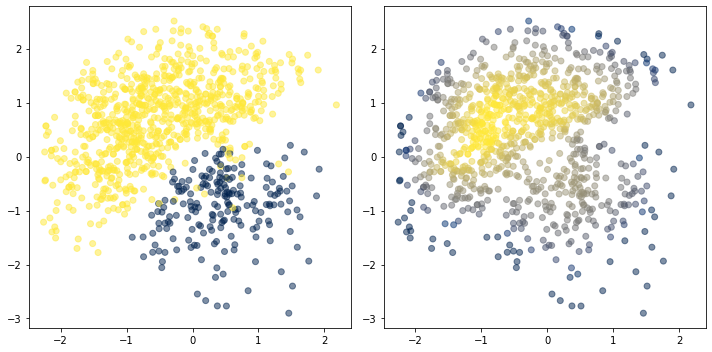

In [ ]:
import matplotlib
import matplotlib.cm as cm

df['logp'] = logp_trained.numpy()
vmin, vmax = np.percentile(df['logp'], [5, 95])
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
colors = {True: mapper.to_rgba(vmax), 
          False: mapper.to_rgba(vmin)}

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(df[0], df[1], c=df['digit'].map(colors), alpha=.5)
ax[1].scatter(df[0], df[1], c=mapper.to_rgba(df['logp']), alpha=.5)
plt.tight_layout();

### Train Classifier

In [ ]:
def _preprocess2(sample):
    image = preprocess_image(sample['image'])
    label = sample['label'] == target_digit
    return image, label

batch_size = 256
train_dataset2 = (blended_dataset
                 .map(lambda _, x: _preprocess2(x))
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3))
                 )
eval_dataset2 = (datasets['test']
                .map(_preprocess2)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE)
                )

In [ ]:
label = tfkl.Dense(100, activation=tf.nn.leaky_relu)(encoder.outputs[0])
label = tfkl.Dense(1, activation='sigmoid')(label)
# label = tfpl.IndependentBernoulli([], tfd.Bernoulli.logits)(label)

In [ ]:
classifier = tfk.Model(
    inputs=encoder.inputs,
    outputs=label)

classifier.compile(optimizer=tf.optimizers.Adam(),
                   loss=tfk.losses.BinaryCrossentropy())

_ = classifier.fit(train_dataset2,
                   epochs=20,
                   validation_data=eval_dataset2)

Epoch 1/20
34/34 [==============================] - 14s 69ms/step - loss: 8.9078 - val_loss: 9.1184
Epoch 2/20
34/34 [==============================] - 11s 45ms/step - loss: 8.6962 - val_loss: 9.0345
Epoch 3/20
34/34 [==============================] - 12s 62ms/step - loss: 8.6210 - val_loss: 8.9328
Epoch 4/20
34/34 [==============================] - 11s 47ms/step - loss: 8.5297 - val_loss: 8.8860
Epoch 5/20
34/34 [==============================] - 12s 65ms/step - loss: 8.5353 - val_loss: 8.8223
Epoch 6/20
34/34 [==============================] - 11s 64ms/step - loss: 8.4761 - val_loss: 8.7521
Epoch 7/20
34/34 [==============================] - 11s 39ms/step - loss: 8.4595 - val_loss: 8.7595
Epoch 8/20
34/34 [==============================] - 10s 38ms/step - loss: 8.4343 - val_loss: 8.7446
Epoch 9/20
34/34 [==============================] - 11s 42ms/step - loss: 8.4348 - val_loss: 8.7229
Epoch 10/20
34/34 [==============================] - 11s 46ms/step - loss: 8.4824 - val_loss: 8.7434

In [ ]:
pred_label = classifier(output_image)

In [ ]:
# df['label_prob'] = pred_label.mean().numpy()
df['label_prob'] = pred_label.numpy()

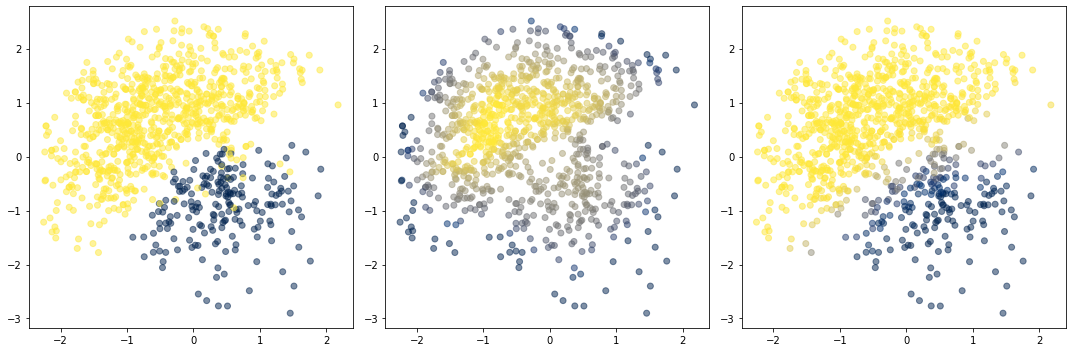

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(df[0], df[1], c=df['digit'].map(colors), alpha=.5)
ax[1].scatter(df[0], df[1], c=mapper.to_rgba(df['logp']), alpha=.5)

norm2 = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper2 = cm.ScalarMappable(norm=norm2, cmap=cm.cividis)
ax[2].scatter(df[0], df[1], c=mapper2.to_rgba(df['label_prob']), alpha=.5)

plt.tight_layout();